In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


In [2]:
target.head()


2020-08-18 14:43:19    150.0
2020-08-18 14:43:20    161.0
2020-08-18 14:43:21    163.0
2020-08-18 14:43:22    156.0
2020-08-18 14:43:23    148.0
Name: power, dtype: float64

In [3]:
df = pd.DataFrame()

In [4]:
df['cube_speed'] = data['speed'] ** 3

In [5]:
df['speed'] = data['speed']

In [6]:
import numpy as np

df['speed_angle'] = data['speed'] * np.sin(np.arctan(data['slope']))

In [7]:
df['speed_acc'] = data['speed'] * data['acceleration']

In [8]:
df.head()

,cube_speed,speed,speed_angle,speed_acc
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050


In [9]:
df.speed_angle.mean()

-0.0027097096125663312

In [10]:
# build the data matrix
data_linear_model = pd.concat(
    {"speed^3": data["speed"] ** 3,
     "speed": data["speed"],
     "speed*sin(alpha)": data["speed"] * np.sin(np.arctan(data["slope"])),
     "speed*acceleration": data["speed"] * data["acceleration"].clip(lower=0)},
    axis=1
)

In [11]:
data_linear_model.mean()["speed*sin(alpha)"]

-0.0027097096125663312

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit

In [13]:
model = RidgeCV()

In [14]:
from sklearn.model_selection import cross_validate

cv = ShuffleSplit(n_splits=4)
scores = cross_validate(model, data_linear_model, target, cv=cv,
                        scoring="neg_mean_absolute_error",
                        return_train_score=True)

In [15]:
scores

{'fit_time': array([0.01087046, 0.00737619, 0.00776291, 0.00783443]),
 'score_time': array([0.00144005, 0.00146461, 0.00137067, 0.00133634]),
 'test_score': array([-73.46442953, -73.08186369, -72.61653281, -73.15776505]),
 'train_score': array([-72.39522085, -72.4013899 , -72.45730787, -72.35419683])}

In [16]:
print(scores['test_score'].mean())

-73.08014776781182


In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

# create the model
linear_model = make_pipeline(StandardScaler(), RidgeCV())

# evaluate the model with cross-validation
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, cv=cv,
    scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_linear_model["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

MAE on test sets:
 [73.23006461 72.1311734  72.89061823 71.2370263 ]
 mean +/- std: 72.372 +/- 0.767 Watts


In [18]:
data_linear_model.head()

,speed^3,speed,speed*sin(alpha),speed*acceleration
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050


In [19]:
print(cv_results_linear_model["estimator"])

[Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])]


In [20]:
cv_results_linear_model

{'fit_time': array([0.01096106, 0.0100801 , 0.01011992, 0.01007986]),
 'score_time': array([0.00154686, 0.00148845, 0.0015223 , 0.00148201]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])],
 'test_score': array([-73.23006461, -72.1311734 , -72.89061823, -71.2370263 ]),
 'train_score': array([-72.35634493, -72.51703894, -72.42974777, -72.6121094 ])}

In [21]:
for estimator in cv_results_linear_model["estimator"]:
    print(estimator[-1].coef_)

[ 5.66427806 32.84904152 80.08105928 10.85618779]
[ 5.68897463 32.83434375 80.99005594 11.34425   ]
[ 6.28736152 32.19112942 80.92397865 11.23297157]
[ 6.18278112 32.4035743  80.61344415 11.27427489]


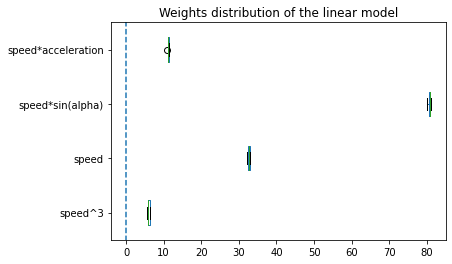

In [22]:
import matplotlib.pyplot as plt
coefs = [
    estimator[-1].coef_ for estimator in cv_results_linear_model["estimator"]]
coefs = pd.DataFrame(coefs, columns=data_linear_model.columns)

ax = coefs.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")

In [23]:
from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv
from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.impute import SimpleImputer

# create the model
hist_model = make_pipeline(StandardScaler(), HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=0
))

# evaluate the model with cross-validation
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_hgbdt = cross_validate(
    hist_model, data, target, cv=cv,
    scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_hgbdt["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

MAE on test sets:
 [44.71263363 43.32059735 42.92460634 43.10264111]
 mean +/- std: 43.515 +/- 0.705 Watts


In [24]:
errors = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

errors = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
  

Linear model - MAE on train sets:
 [72.35634493 72.51703894 72.42974777 72.6121094 ]
 mean +/- std: 72.479 +/- 0.096 Watts
Linear model - MAE on test sets:
 [73.23006461 72.1311734  72.89061823 71.2370263 ]
 mean +/- std: 72.372 +/- 0.767 Watts
Histogram GBDT - MAE on train sets:
 [41.09640232 38.02961142 38.79560993 39.40708105]
 mean +/- std: 39.332 +/- 1.129 Watts
Histogram GBDT - MAE on test sets:
 [44.71263363 43.32059735 42.92460634 43.10264111]
 mean +/- std: 43.515 +/- 0.705 Watts


In [25]:
len(set(data.index.date))

4

In [26]:
import numpy as np

unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


In [29]:
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(data.index.date)
cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    linear_model, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt = cross_validate(
    hist_model, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)

errors = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

errors = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

Linear model - MAE on train sets:
 [65.1874884  65.22169376 61.56060983 66.38219588]
 mean +/- std: 64.588 +/- 1.813 Watts
Linear model - MAE on test sets:
 [63.61500973 64.55717906 71.81603163 59.06431081]
 mean +/- std: 64.763 +/- 4.571 Watts
Histogram GBDT - MAE on train sets:
 [39.49957639 40.75980377 36.57874345 41.18176443]
 mean +/- std: 39.505 +/- 1.799 Watts
Histogram GBDT - MAE on test sets:
 [47.70496008 48.03461081 53.82834906 47.95896479]
 mean +/- std: 49.382 +/- 2.570 Watts


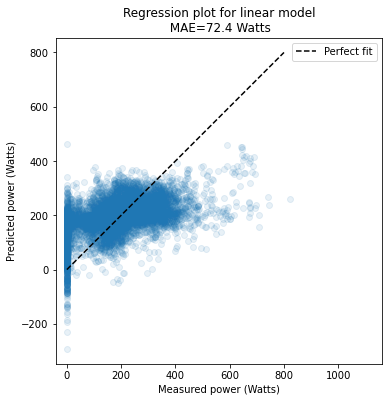

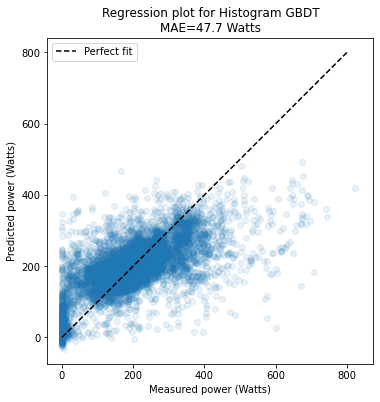

In [32]:
from sklearn.metrics import mean_absolute_error

# extract the dataset
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

# fit models and collect predictions
linear_model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = linear_model.predict(data_linear_model_test)

hist_model.fit(data_train, target_train)
target_predicted_hgbdt = hist_model.predict(data_test)

# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

In [33]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

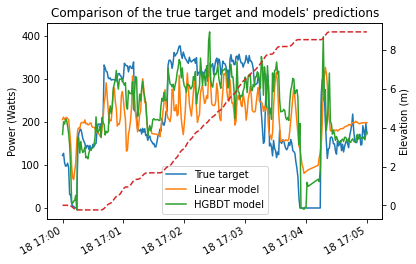

In [37]:
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hist_model.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target")
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")
  